In [2]:
using Arpack
using LinearAlgebra
using CairoMakie
using LaTeXStrings
using Statistics

In [3]:
function hamiltonian(delta1, delta2, delta3, v, q, K1, K3, K5)
    ham = [v * dot(q, normalize(K1)) delta1 conj(delta3); conj(delta1) v * dot(q, normalize(K3)) delta2; 
    delta3 conj(delta2) v * dot(q, normalize(K5))]
    return ham
end

hamiltonian (generic function with 1 method)

In [4]:
function cdag_c(H_eff, coord)
    # ground state
    psi_0 = eigvecs(Hermitian(H_eff))[:, 1]
    mat = zeros((3, 3))
    mat[coord[1], coord[2]] = 1
    return dot(psi_0, mat * psi_0)
end

cdag_c (generic function with 1 method)

In [5]:
function form_factor(k, q, n)
    normalization = 1/sqrt(norm(k)^2 + 1) * 1/sqrt(norm(q)^2 + 1)
    # extract polar angles
    if q[1] < 0
        theta_q = atan(q[2]/q[1])  + pi
    else
        theta_q = atan(q[2]/q[1])
    end
    if k[1] < 0
        theta_k = atan(k[2]/k[1])  + pi
    else
        theta_k = atan(k[2]/k[1])
    end
    return (1/normalization) * (1 + norm(k) * norm(q) * exp(im * n * (theta_q - theta_k)))
end

form_factor (generic function with 1 method)

In [6]:
function rot(theta, v)
    R = [cos(theta) -sin(theta); sin(theta) cos(theta)]
    return R * v
end

rot (generic function with 1 method)

In [7]:
function tri_lattice(center, spacing, n_pts)
    cx, cy = center
    points = []
    # Calculate the points in a triangular lattice
    for i in -n_pts:n_pts
        for j in -n_pts:n_pts
            if abs(i + j) <= n_pts
                x = cx + spacing * (i * 1.5)
                y = cy + spacing * (sqrt(3) * (j + 0.5 * (i % 2)))
                x, y = rot(-pi/6, [x, y])
                push!(points, [x, y])
            end
        end
    end
    return points
end

tri_lattice (generic function with 1 method)

In [8]:
function delta_hartree(Km, Kn, q, ccdag, n, spacing, pts)
    ffq = form_factor(Km + q, Kn + q, n)
    grid = tri_lattice((0, 0), spacing, pts)
    integral = 0
    for i in 1:length(grid)
        k = grid[i]
        ffk = form_factor(Kn + k, Km + k, n)
        integral += ccdag * ffk
    end
    integral = integral/length(grid)
    return ffq * integral
end

delta_hartree (generic function with 1 method)

In [9]:
function delta_fock(Km, Kn, q, ccdag, n, spacing, pts, Vq)
    grid = tri_lattice((0, 0), spacing, pts)
    integral = 0
    for i in 1:length(grid)
        p = grid[i]
        ff1 = form_factor(Km + q + p, Km + q, n)
        ff2 = form_factor(Kn + q, Kn + q + p, n)
        integral += Vq * ccdag * ff1 * ff2
    end
    integral = integral/length(grid)
    return -integral
end

delta_fock (generic function with 1 method)

In [10]:
function delta_iter(Km, Kn, q, ccdag, n, spacing, pts, Vg, Vk)
    return Vg * delta_hartree(Km, Kn, q, ccdag, n, spacing, pts) + delta_fock(Km, Kn, q, ccdag, n, spacing, pts, Vk)
end

delta_iter (generic function with 1 method)

In [11]:
function sc_iter(H_eff, q, n, v, spacing, pts, K1, K3, K5, Vg, Vk)
    # 1. Acquire psi_0
    # 2. Acquire ccdag and Lambda
    # 3. Update Delta
    # 4. Update Heff 
    # 5. Repeat
    coord1 = [2, 1] # Delta1
    coord2 = [3, 2] # Delta2
    coord3 = [1, 3] # Delta3

    cdagc1 = cdag_c(H_eff, coord1)
    cdagc2 = cdag_c(H_eff, coord2)
    cdagc3 = cdag_c(H_eff, coord3)

    delta1 = delta_iter(K1, K3, q, cdagc1, n, spacing, pts, Vg, Vk)
    delta2 = delta_iter(K3, K5, q, cdagc2, n, spacing, pts, Vg, Vk)
    delta3 = delta_iter(K5, K1, q, cdagc3, n, spacing, pts, Vg, Vk)

    H_eff1 = hamiltonian(delta1, delta2, delta3, v, q, K1, K3, K5)
    
    return H_eff1
end

sc_iter (generic function with 1 method)

In [12]:
function sc_loop(delta0, iterations, q, n, v, spacing, pts, K1, K3, K5, Vg, Vk)
    H = hamiltonian(delta0, delta0, delta0, v, q, K1, K3, K5)
    for i in 1:iterations
        H = sc_iter(H, q, n, v, spacing, pts, K1, K3, K5, Vg, Vk)
    end
    return H
end

sc_loop (generic function with 1 method)

In [62]:
# parameters
a = 1 # lattice constant
v = 10^(-2) # Fermi velocity
n = 2 # winding number
delta0 = 1 # initial MF
iters = 10
Vg = 1
Vq = 1
# grid parameters
spacing = 10^(-8)
pts = 10^(2)

100

In [13]:
G1 = [2*pi/a, -2*pi/(sqrt(3) * a)]
G2 = [0, 4*pi/(sqrt(3) * a)]
G3 = -G1 - G2

K1 = (2/3) * G1 + (1/3) * G2
K3 = K1 - G1
K5 = K1 + G3

2-element Vector{Float64}:
 -2.0943951023931957
 -3.6275987284684357

In [65]:
q = [1, 1]
sc_loop(delta0, iters, q, n, v, spacing, pts, K1, K3, K5, Vg, Vq)

3×3 Matrix{ComplexF64}:
     0.01+0.0im             63359.9+1.887e5im        5.322e-6-8.38787e-6im
  63359.9-1.887e5im      0.00366025+0.0im         -2.55523e-5-3.37007e-5im
 5.322e-6+8.38787e-6im  -2.55523e-5+3.37007e-5im   -0.0136603+0.0im

In [66]:
# get the eigenvector corresponding to the band-index (l) @ k = (kx, ky)
function eigen_vec(l, x, y, delta0, iters, n, v, spacing, pts, K1, K3, K5, Vg, Vq)
    ham = sc_loop(delta0, iters, [x, y], n, v, spacing, pts, K1, K3, K5, Vg, Vq)
    vecs = eigvecs(Hermitian(ham))
    return vecs[:, l]
end

eigen_vec (generic function with 1 method)

In [67]:
# compute the phase difference between wavefunction at (x1, y1) and (x2, y2)
function theta(l, x1, y1, x2, y2, delta0, iters, n, v, spacing, pts, K1, K3, K5, Vg, Vq)
    ev1 = eigen_vec(l, x1, y1, delta0, iters, n, v, spacing, pts, K1, K3, K5, Vg, Vq)
    ev2 = eigen_vec(l, x2, y2, delta0, iters, n, v, spacing, pts, K1, K3, K5, Vg, Vq)
    return dot(ev2, ev1) / abs(dot(ev2, ev1))
end

theta (generic function with 1 method)

In [68]:
# Berry flux through a plaquette with corners (x1, y1), (x2, y2), (x3, y3), (x4, y4)
function flux(l, x1, y1, x2, y2, x3, y3, x4, y4, delta0, iters, n, v, spacing, pts, K1, K3, K5, Vg, Vq)
    big_theta = theta(l, x2, y2, x1, y1, delta0, iters, n, v, spacing, pts, K1, K3, K5, Vg, Vq) *
        theta(l, x3, y3, x2, y2, delta0, iters, n, v, spacing, pts, K1, K3, K5, Vg, Vq) * 
        theta(l, x4, y4, x3, y3, delta0, iters, n, v, spacing, pts, K1, K3, K5, Vg, Vq) * 
    theta(l, x1, y1, x4, y4, delta0, iters, n, v, spacing, pts, K1, K3, K5, Vg, Vq)
    # Numerical instability around flux = pi, so we always force it to choose +pi
    if abs(imag(big_theta)) < 10^(-12)
        return abs(angle(big_theta))
    else
        return angle(big_theta)
    end
end

flux (generic function with 1 method)

In [69]:
# Berry curvature over all plaquettes
function berry_curvature(l, points, pd, delta0, iters, n, v, spacing, pts, K1, K3, K5, Vg, Vq)
    berry_list = Vector{Float64}()
    avg_k_x = Vector{Float64}()
    avg_k_y = Vector{Float64}()
    for i in 1:(pd - 1)
        for j in 1:(pd - 1)
            x1 = points[i, j, 1]
            y1 = points[i, j, 2]
            
            x2 = points[i + 1, j, 1]
            y2 = points[i + 1, j, 2]
            
            x3 = points[i + 1, j + 1, 1]
            y3 = points[i + 1, j + 1, 2]
            
            x4 = points[i, j + 1, 1]
            y4 = points[i, j + 1, 2]
            
            x_avg = (x1 + x2 + x3 + x4)/4
            y_avg = (y1 + y2 + y3 + y4)/4
            
            append!(avg_k_x, x_avg)
            append!(avg_k_y, y_avg)
            curvature = flux(l, x1, y1, x2, y2, x3, y3, x4, y4, delta0, iters, n, v, spacing, pts, K1, K3, K5, Vg, Vq)
            append!(berry_list, curvature)
        end
    end
    return berry_list, avg_k_x, avg_k_y
end

berry_curvature (generic function with 1 method)

In [70]:
# This generates a line of points in K-space
function gen_list(xlim, n, shift, y)
    x_vals = range(-xlim + shift, shift, n)
    line_vals = Array{Float64}(undef, n, 2)
    for i in 1:n
        line_vals[i, :] = [x_vals[i], y]
    end
    return line_vals
end
# This generates a single unit cell of points in K-space
function gen_grid(xlim, n)
    step = range(0, xlim, n)
    grid = Array{Float64}(undef, n, n, 2)
    for i in 1:n
        grid[:, i, :] = gen_list(xlim, n, 0.5*step[i], (sqrt(3)/2)*step[i])
    end
    return grid
end
# Shift a grid over
function shift_grid(grid, n, xshift, yshift)
    new_grid = copy(grid)
    for i in 1:n
        new_grid[:, i, 2] += yshift * ones(size(grid[:, i, 2]))
        new_grid[:, i, 1] += xshift * ones(size(grid[:, i, 1]))
    end
    return new_grid
end
# This generates a line of points in K-space
function make_line(x0, x1, n, y)
    x_vals = range(x0, x1, n)
    line_vals = Array{Float64}(undef, n, 2)
    for i in 1:n
        line_vals[i, :] = [x_vals[i], y]
    end
    return line_vals
end

# draw a square around k of dimensions radius x radius (with point-density n)
function k_zone(k, n, radius)
    kx = k[1]
    ky = k[2]
    grid = Array{Float64}(undef, n, n, 2)
    ky_pts = range(ky - radius/2, ky + radius/2, n)
    for i in 1:n
        grid[:, i, :] = make_line(kx - radius/2, kx + radius/2, n, ky_pts[i])
    end
    return grid
end

k_zone (generic function with 1 method)

In [71]:
# pd is point-density
pd = 20
q_grid = k_zone([0, 0], pd, 10^(-3))

20×20×2 Array{Float64, 3}:
[:, :, 1] =
 -0.0005       -0.0005       -0.0005       …  -0.0005       -0.0005
 -0.000447368  -0.000447368  -0.000447368     -0.000447368  -0.000447368
 -0.000394737  -0.000394737  -0.000394737     -0.000394737  -0.000394737
 -0.000342105  -0.000342105  -0.000342105     -0.000342105  -0.000342105
 -0.000289474  -0.000289474  -0.000289474     -0.000289474  -0.000289474
 -0.000236842  -0.000236842  -0.000236842  …  -0.000236842  -0.000236842
 -0.000184211  -0.000184211  -0.000184211     -0.000184211  -0.000184211
 -0.000131579  -0.000131579  -0.000131579     -0.000131579  -0.000131579
 -7.89474e-5   -7.89474e-5   -7.89474e-5      -7.89474e-5   -7.89474e-5
 -2.63158e-5   -2.63158e-5   -2.63158e-5      -2.63158e-5   -2.63158e-5
  2.63158e-5    2.63158e-5    2.63158e-5   …   2.63158e-5    2.63158e-5
  7.89474e-5    7.89474e-5    7.89474e-5       7.89474e-5    7.89474e-5
  0.000131579   0.000131579   0.000131579      0.000131579   0.000131579
  0.000184211   0.000

In [72]:
Vg = 1 # hartree potential
Vq = 0 # Fock potential
# Only evolve hartree
h_fluxes, h_akx, h_aky = berry_curvature(1, q_grid, pd, delta0, iters, n, v, spacing, pts, K1, K3, K5, Vg, Vq)

([2.0631825241312907e-15, 2.063507784783036e-15, 2.0630741039140417e-15, 2.0636975201632213e-15, 2.062884368533857e-15, 2.0629927887511057e-15, 2.0632096291856028e-15, 2.0625862129364236e-15, 2.063372259511476e-15, 0.00022668774647950307  …  2.063061116321318e-15, 2.063324143242424e-15, 2.063620981968322e-15, 2.06312067583689e-15, 2.0633839029057775e-15, 2.0633774542057225e-15, 2.063231877035358e-15, 2.0631784841811786e-15, 2.06305344094234e-15, 2.063602440714892e-15], [-0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158  …  0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158], [-0.0004736842105263158, -0.00042105263157894734, -

  0.035940 seconds (368.36 k allocations: 16.655 MiB)


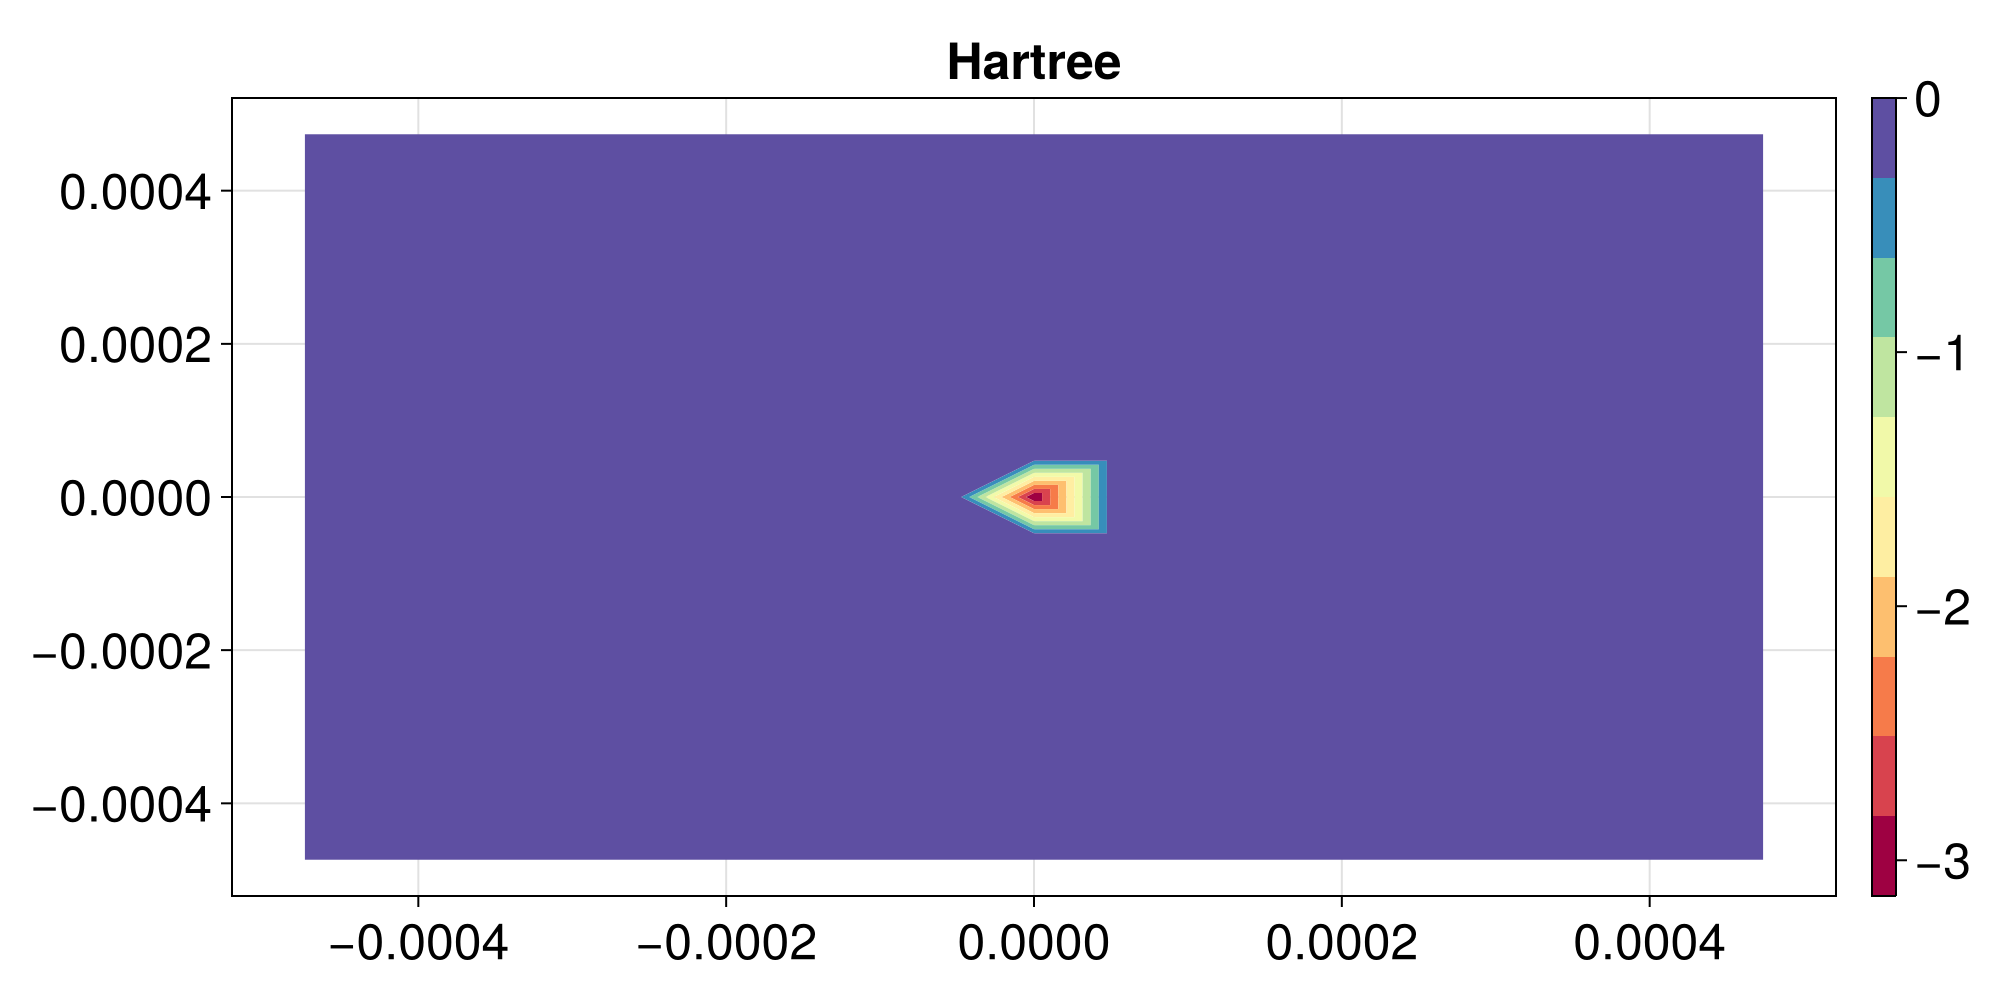

In [86]:
@time begin
    fig = Figure(size=(1000, 500), fontsize=25)
        
    ax = Axis(fig[1, 1], title = "Hartree")
    tricontourf!(ax, h_akx, h_aky, h_fluxes, colormap = :Spectral)

    X, ax, tr1 = tricontourf(h_akx, h_aky, h_fluxes, colormap = :Spectral)
    cb1 = Colorbar(fig[1, 2], tr1)
    fig
        
    end

In [74]:
Vg = 0 # hartree potential
Vq = 1 # Fock potential
# Only evolve fock
f_fluxes, f_akx, f_aky = berry_curvature(1, q_grid, pd, delta0, iters, n, v, spacing, pts, K1, K3, K5, Vg, Vq)

([5.689590737433066e-19, 5.590310063415051e-19, 6.118421228281355e-19, 7.068350893335115e-19, 6.882898319717689e-19, 7.747819451347019e-19, 6.899514135334554e-19, 8.379152373854145e-19, 9.543274594199651e-19, 7.755735217440763e-19  …  1.1068276179201457e-15, 3.983718249999486e-18, 8.823688127995344e-19, 5.867032012465399e-19, 8.50776674883306e-19, 7.639100281241955e-19, 7.067557174498222e-19, 7.657067557395099e-19, 8.652289586030483e-19, 8.411489386523582e-19], [-0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158  …  0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158], [-0.0004736842105263158, -0.00042105263157894734, -0.000368

  0.036564 seconds (378.41 k allocations: 16.865 MiB)


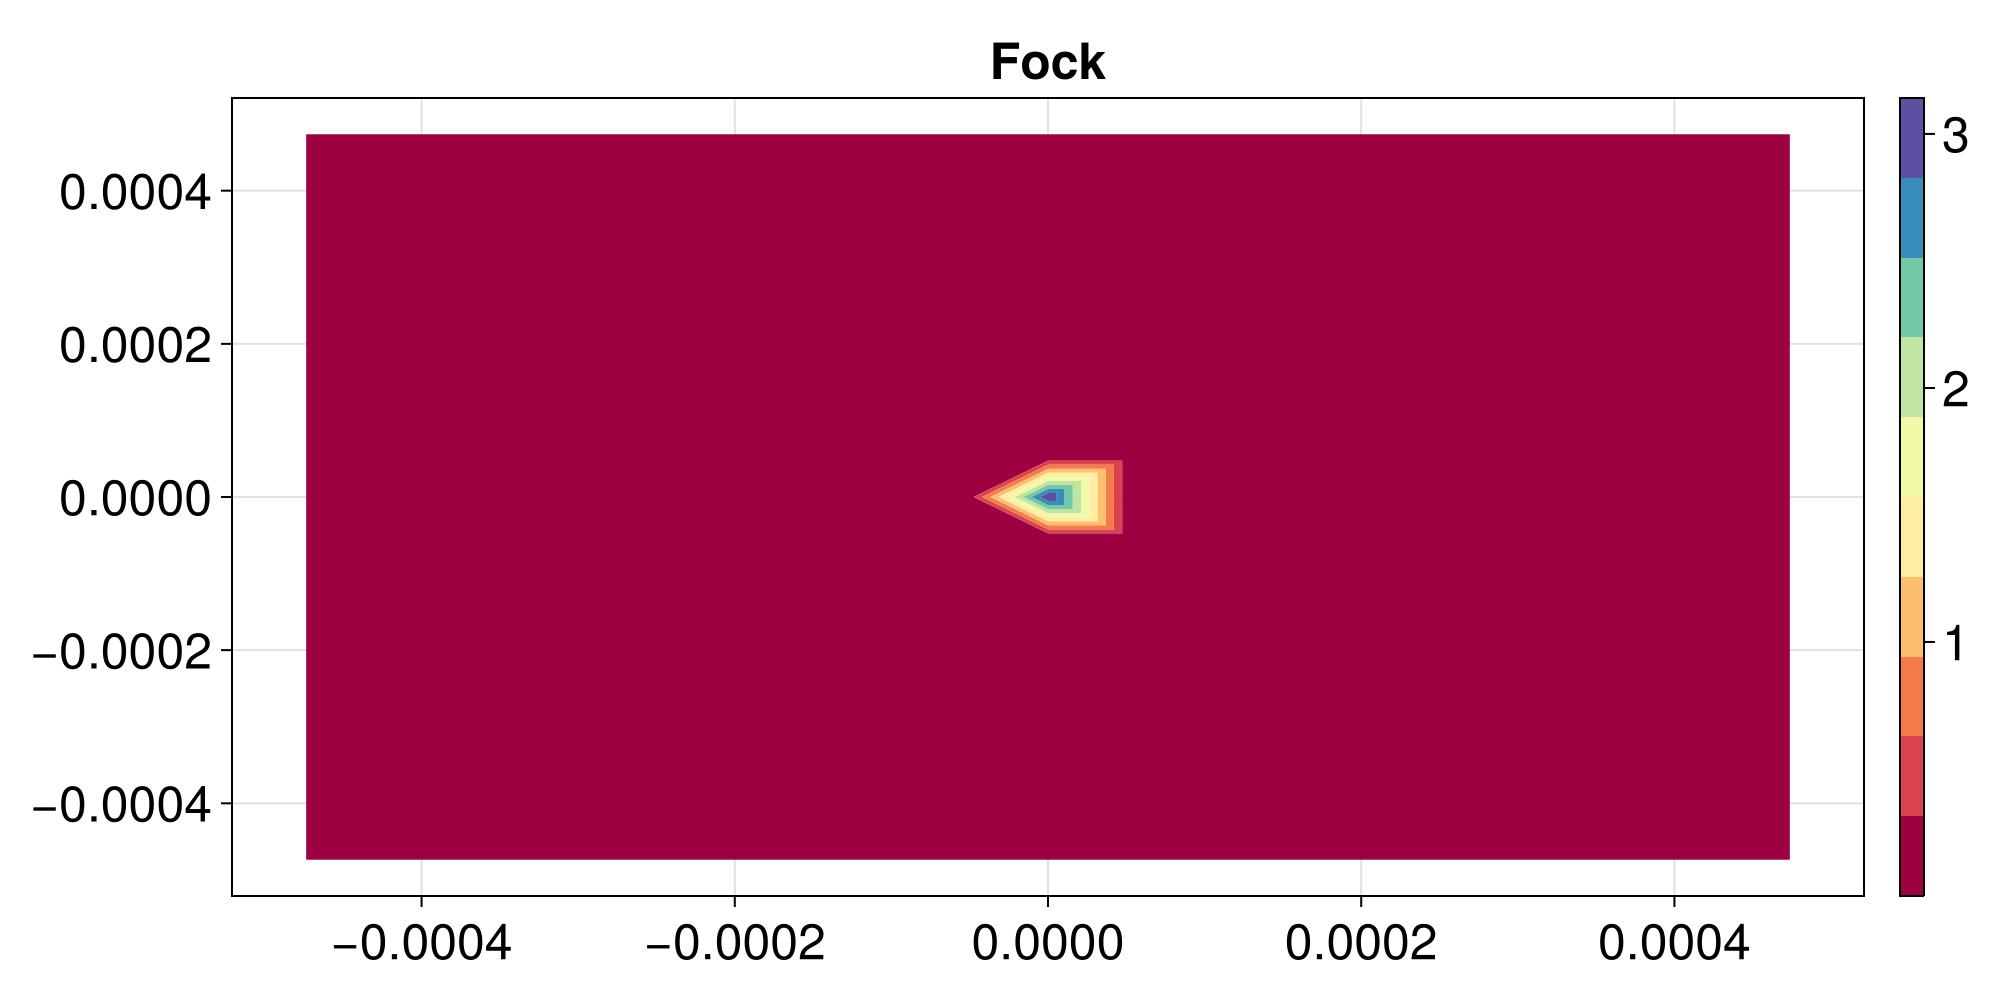

In [79]:
@time begin
    fig = Figure(size=(1000, 500), fontsize=25)
        
    ax = Axis(fig[1, 1], title = "Fock")
    tricontourf!(ax, f_akx, f_aky, f_fluxes, colormap = :Spectral)

    X, ax, tr1 = tricontourf(f_akx, f_aky, f_fluxes, colormap = :Spectral)
    cb1 = Colorbar(fig[1, 2], tr1)
    fig
        
    end

In [76]:
Vg = 1 # hartree potential
Vq = 1 # Fock potential
# No evolution
fluxes_0, akx_0, aky_0 = berry_curvature(1, q_grid, pd, delta0, 0, n, v, spacing, pts, K1, K3, K5, Vg, Vq)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158  …  0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158], [-0.0004736842105263158, -0.00042105263157894734, -0.0003684210526315789, -0.00031578947368421053, -0.0002631578947368421, -0.00021052631578947367, -0.00015789473684210527, -0.00010526315789473683, -5.2631578947368424e-5, 0.0  …  0.0, 5.263157894736842e-5, 0.00010526315789473683, 0.00015789473684210527, 0.0002105263157894737, 0.0002631578947368421, 0.00031578947368421053, 0.00036842105263157896, 0.000421052631578947

  0.036091 seconds (379.59 k allocations: 16.971 MiB)


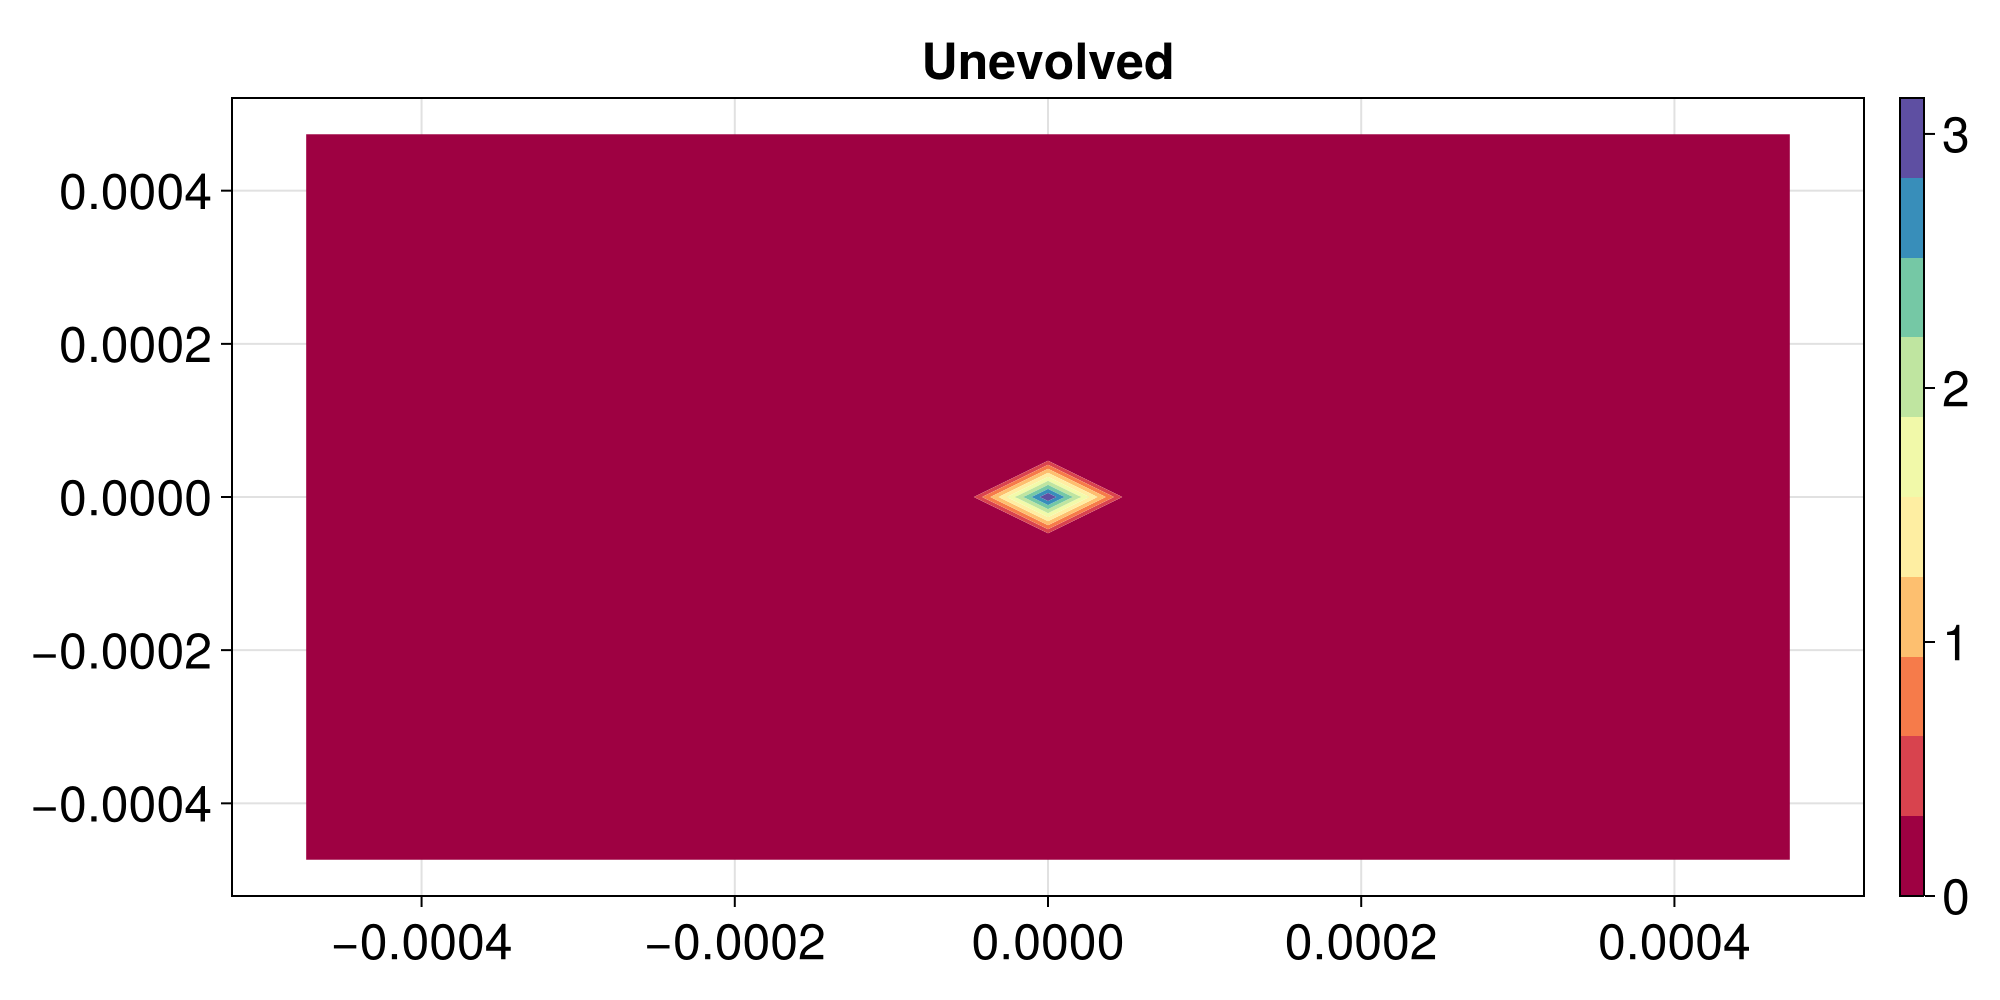

In [80]:
@time begin
    fig = Figure(size=(1000, 500), fontsize=25)
        
    ax = Axis(fig[1, 1], title = "Unevolved")
    tricontourf!(ax, akx_0, aky_0, fluxes_0, colormap = :Spectral)

    X, ax, tr1 = tricontourf(akx_0, aky_0, fluxes_0, colormap = :Spectral)
    cb1 = Colorbar(fig[1, 2], tr1)
    fig
        
    end

In [82]:
Vg = 1 # hartree potential
Vq = 1 # Fock potential
fluxes, akx, aky = berry_curvature(1, q_grid, pd, delta0, iters, n, v, spacing, pts, K1, K3, K5, Vg, Vq)

([2.486107669431017e-7, 2.5381386682308507e-7, 2.572446563247511e-7, 2.596252414889692e-7, 2.6131736444905773e-7, 2.625215398843129e-7, 2.633585541138325e-7, 2.63906065625655e-7, 2.6421478499451737e-7, 2.643143939403919e-7  …  2.4012316318054212e-6, 7.530279226943607e-8, 2.2764984405150674e-7, 2.490340273420535e-7, 2.5675012950519164e-7, 2.6048639477772984e-7, 2.625898920196796e-7, 2.638943694181759e-7, 2.647628704753806e-7, 2.6537462720160327e-7], [-0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158, -0.0004736842105263158  …  0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158, 0.0004736842105263158], [-0.0004736842105263158, -0.00042105263157894734, -0.0003684210526315789

  0.054188 seconds (360.94 k allocations: 16.458 MiB, 12.78% gc time)


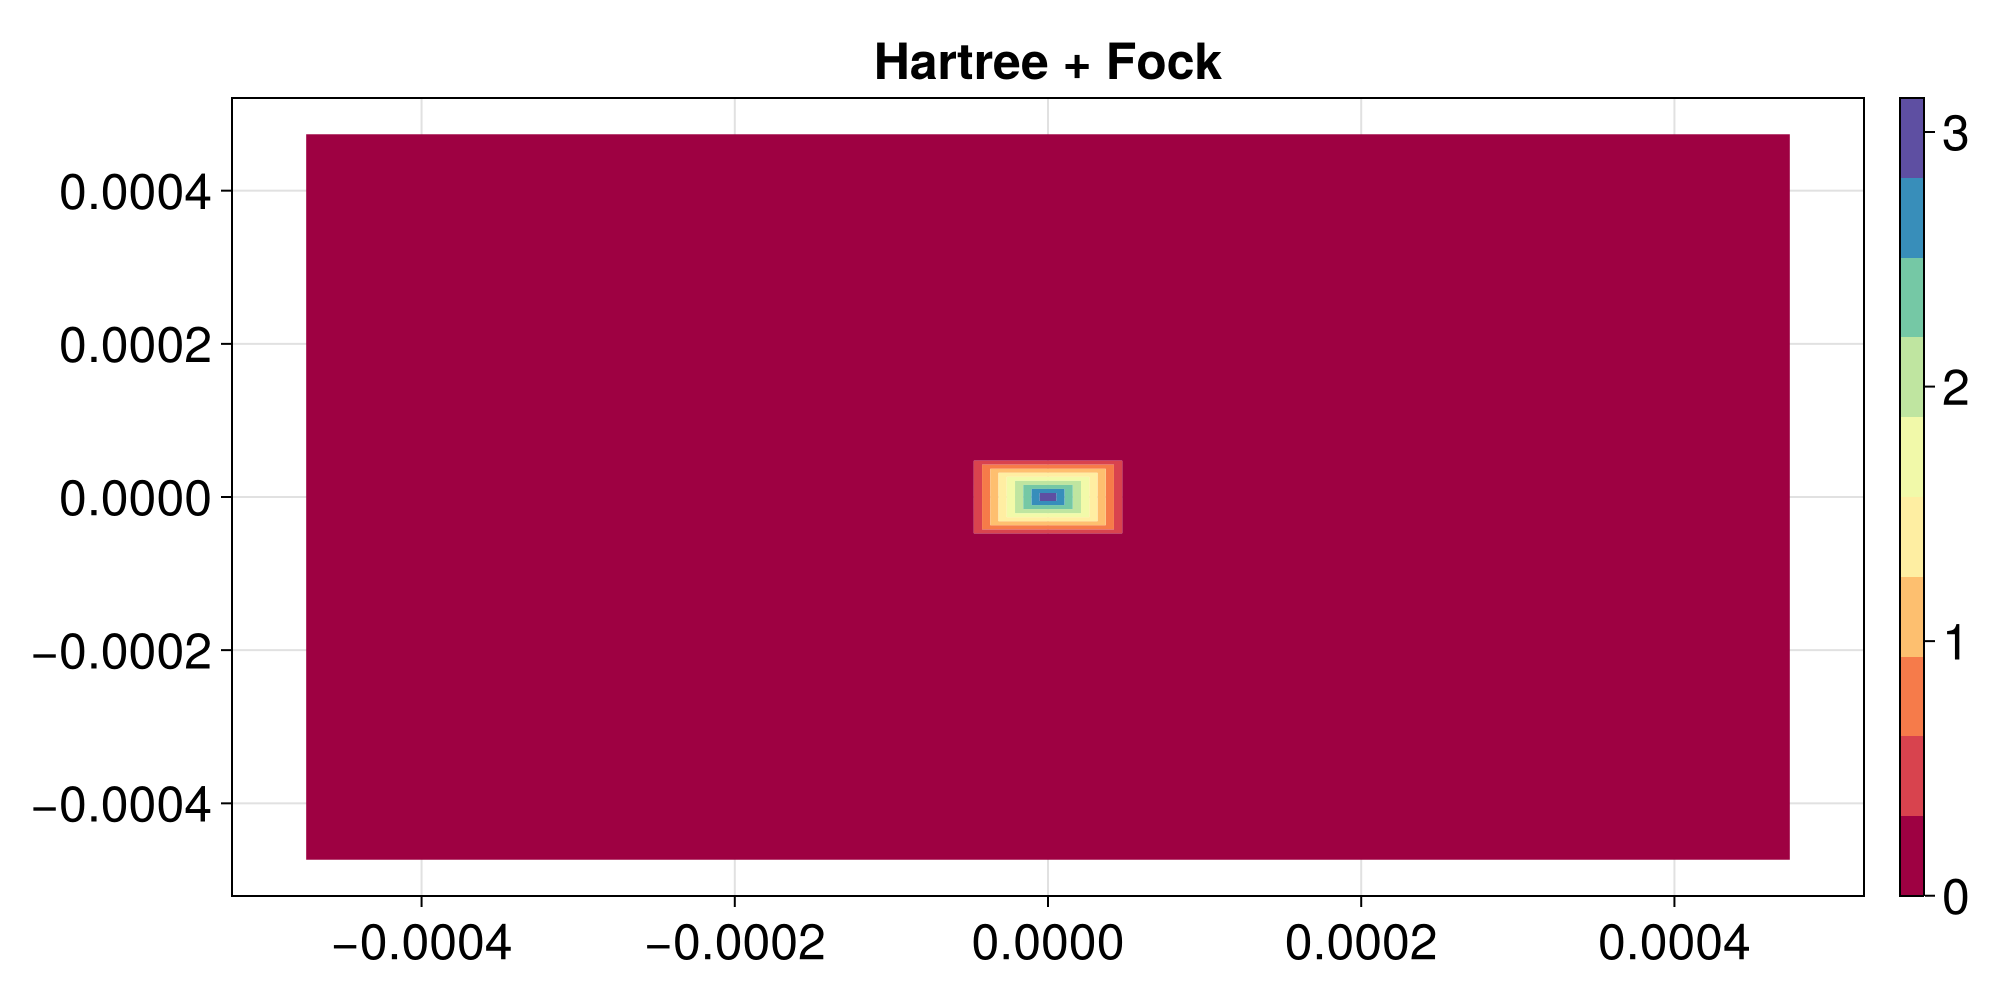

In [83]:
@time begin
    fig = Figure(size=(1000, 500), fontsize=25)
        
    ax = Axis(fig[1, 1], title = "Hartree + Fock")
    tricontourf!(ax, akx, aky, fluxes, colormap = :Spectral)

    X, ax, tr1 = tricontourf(akx, aky, fluxes, colormap = :Spectral)
    cb1 = Colorbar(fig[1, 2], tr1)
    fig
        
    end

  1.688131 seconds (6.70 M allocations: 419.996 MiB, 11.99% gc time, 88.19% compilation time)


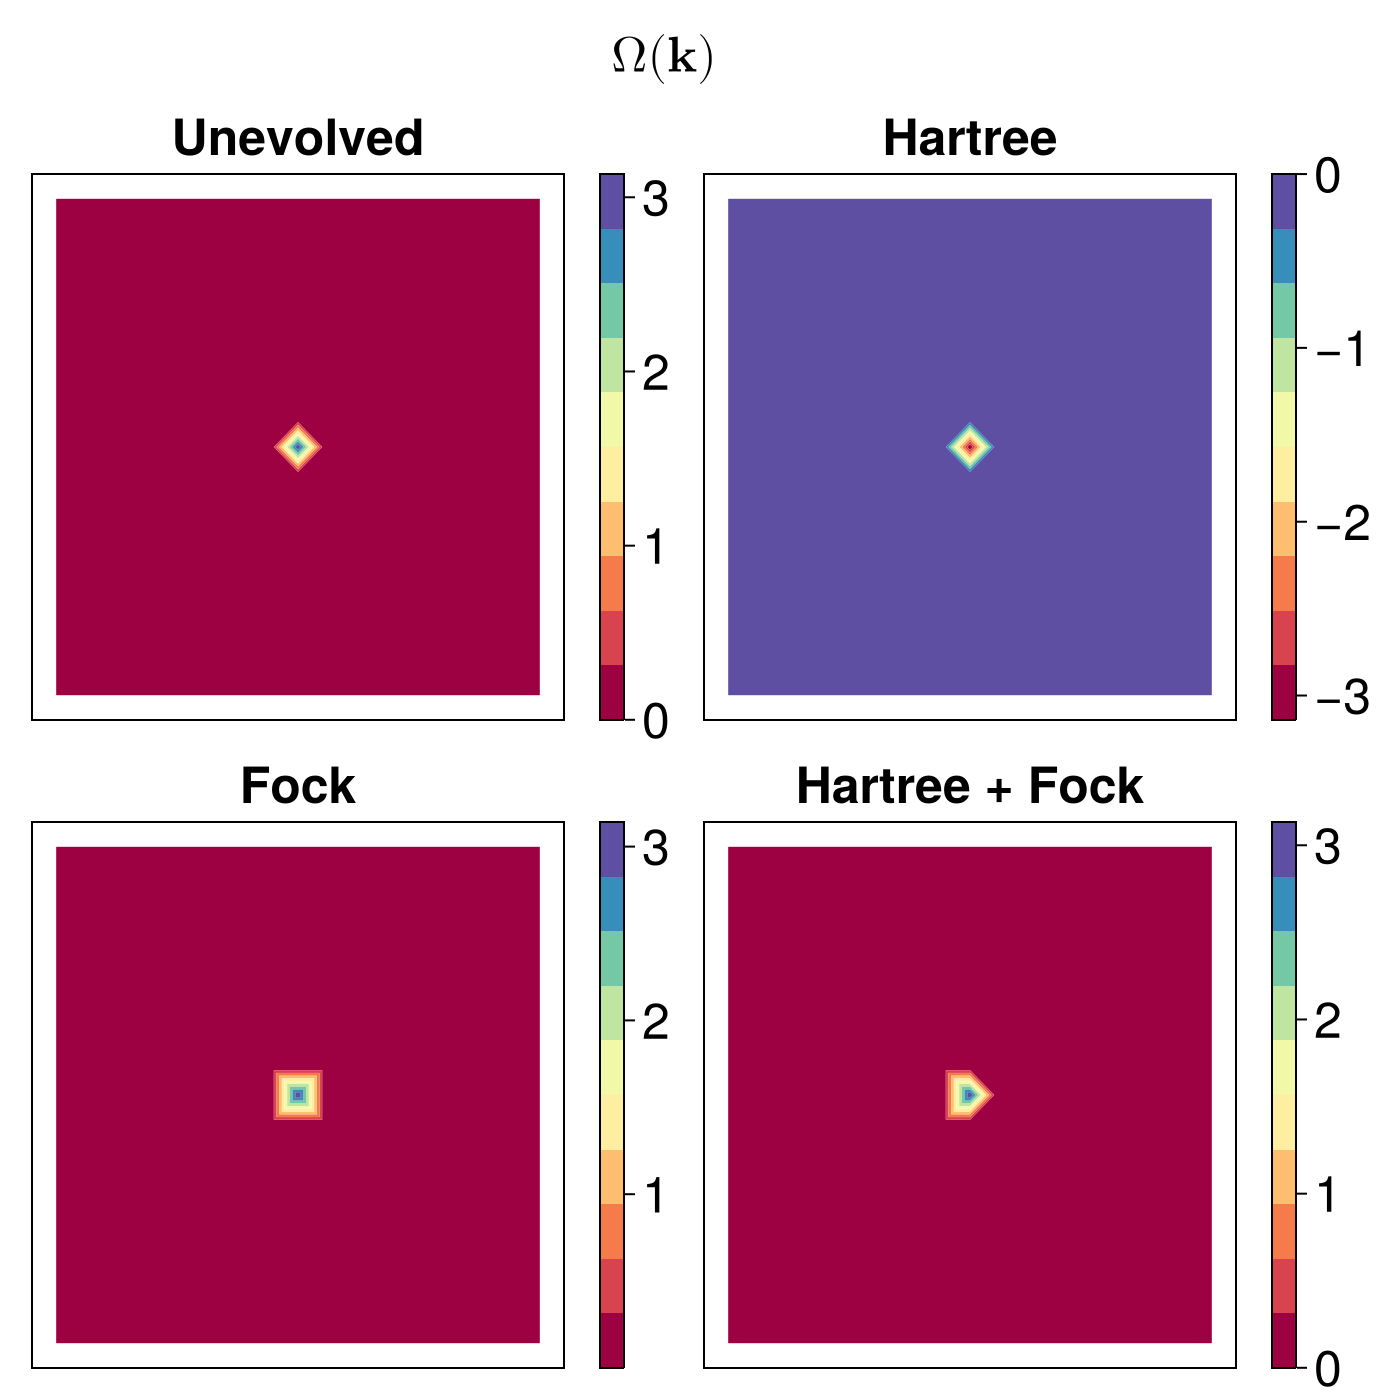

In [93]:
@time begin
    fig = Figure(size=(700, 700), fontsize=25)
        
    ax1 = Axis(fig[1, 1], title = "Unevolved")
    tricontourf!(ax1, akx, aky, fluxes, colormap = :Spectral)
    hidedecorations!(ax1)
    X, ax1, tr1 = tricontourf(akx, aky, fluxes, colormap = :Spectral)
    cb1 = Colorbar(fig[1, 2], tr1)


    ax2 = Axis(fig[1, 3], title = "Hartree")
    tricontourf!(ax2, h_akx, h_aky, h_fluxes, colormap = :Spectral)
    hidedecorations!(ax2)
    X, ax2, tr2 = tricontourf(h_akx, h_aky, h_fluxes, colormap = :Spectral)
    cb2 = Colorbar(fig[1, 4], tr2)

    ax3 = Axis(fig[2, 1], title = "Fock")
    tricontourf!(ax3, f_akx, f_aky, f_fluxes, colormap = :Spectral)
    hidedecorations!(ax3)
    X, ax3, tr3 = tricontourf(f_akx, f_aky, f_fluxes, colormap = :Spectral)
    cb3 = Colorbar(fig[2, 2], tr3)


    ax4 = Axis(fig[2, 3], title = "Hartree + Fock")
    tricontourf!(ax4, akx, aky, fluxes, colormap = :Spectral)
    hidedecorations!(ax4)
    X, ax4, tr4 = tricontourf(akx, aky, fluxes, colormap = :Spectral)
    cb4 = Colorbar(fig[2, 4], tr4)

    ax = Axis(fig[:, :], title = L"\Omega (\textbf{k})", titlegap = 45)
    hidedecorations!(ax, label = false)
    hidespines!(ax)

    fig
        
    end

<font size="12">Fock Pancharatnam Overlap</font>

In [62]:
a = 1 # lattice constant

1

In [63]:
G1 = [2*pi/a, -2*pi/(sqrt(3) * a)]
G2 = [0, 4*pi/(sqrt(3) * a)]
G3 = -G1 - G2

K1 = (2/3) * G1 + (1/3) * G2
K3 = K1 - G1
K5 = K1 + G3

2-element Vector{Float64}:
 -2.0943951023931957
 -3.6275987284684357

In [130]:
# parameters
v = 0 # Fermi velocity
kF = 10^(-4) * norm(K1)
Vg = 0
Vq = 1

delta0 = (-1/3) * pi * Vq * kF^2 # initial MF
iters = 10
# grid parameters
spacing = 10^(-8)
pts = 10^(2)

100

In [131]:
n_list = range(0, 10^10, 100)

0.0:1.01010101010101e8:1.0e10

In [132]:
overlaps = Array{Float64}(undef, length(n_list))
for i in 1:length(n_list)
    n = n_list[i]
    q1 = [kF, 0]
    H1 = sc_loop(delta0, iters, q1, n, v, spacing, pts, K1, K3, K5, Vg, Vq)
    v1 = normalize(eigvecs(Hermitian(H1))[:, 1])

    q2 = [kF * cos(2 * pi/3), kF * sin(2 * pi/3)]
    H2 = sc_loop(delta0, iters, q2, n, v, spacing, pts, K1, K3, K5, Vg, Vq)
    v2 = normalize(eigvecs(Hermitian(H2))[:, 1])

    q3 = [kF * cos(4 * pi/3), kF * sin(4 * pi/3)]
    H3 = sc_loop(delta0, iters, q3, n, v, spacing, pts, K1, K3, K5, Vg, Vq)
    v3 = normalize(eigvecs(Hermitian(H3))[:, 1])

    p_overlap = dot(v1, v2) * dot(v2, v3) * dot(v3, v1)
    overlaps[i] = angle(p_overlap)
end

In [133]:
@show overlaps

overlaps = [0.0, 6.6153487092340284e-9, -3.418067781547623e-9, -2.9030138794831575e-9, -5.197889038743953e-9, 1.906522316850495e-9, 2.54200757455897e-9, -3.3705776010711525e-8, 1.2324285168841871e-8, 1.2817003010517288e-8, -1.2212485057779052e-8, -4.3836415621030825e-8, 3.303544182978108e-8, -2.0005275833332165e-7, -6.059192866188566e-8, -2.499040870505284e-8, -0.0017127377138142993, 2.742922206985062e-9, -1.0678883181414009e-16, -1.5703347182476069e-12, -4.1371576838573994e-7, -1.7775291013467263e-7, -2.730476626563916e-7, -2.850238885807428e-6, 3.804434647136615e-7, 5.360221754214933e-7, 8.217220212911654e-7, 1.4681050800031265e-7, -6.621811874677937e-8, -1.1383054599048815e-6, 5.688496758381322e-8, -5.958851461983147e-7, 7.577858459693439e-6, 8.136248882345759e-6, 3.220870074657731e-5, 0.0014531816919084875, 0.0001430698161394038, 2.9100491745177145e-6, -9.682370472478436e-6, -1.4700747018554515e-6, -1.2561850675663805e-6, 1.9326305101199203e-7, -1.5783441133276116e-8, -1.4311312623

100-element Vector{Float64}:
  0.0
  6.6153487092340284e-9
 -3.418067781547623e-9
 -2.9030138794831575e-9
 -5.197889038743953e-9
  1.906522316850495e-9
  2.54200757455897e-9
 -3.3705776010711525e-8
  1.2324285168841871e-8
  1.2817003010517288e-8
 -1.2212485057779052e-8
 -4.3836415621030825e-8
  3.303544182978108e-8
  ⋮
 -1.1229406520842954e-10
 -0.0017795163053658924
 -1.2506843688535854e-6
  1.3365687357668604e-5
  3.2677629424510764e-7
 -6.664453080136554e-5
 -2.483742284821654e-6
 -6.984355833677238e-6
 -2.1384980860516537e-5
 -1.090877095458012e-5
  1.3675488389392502e-6
  8.852304328243574e-6

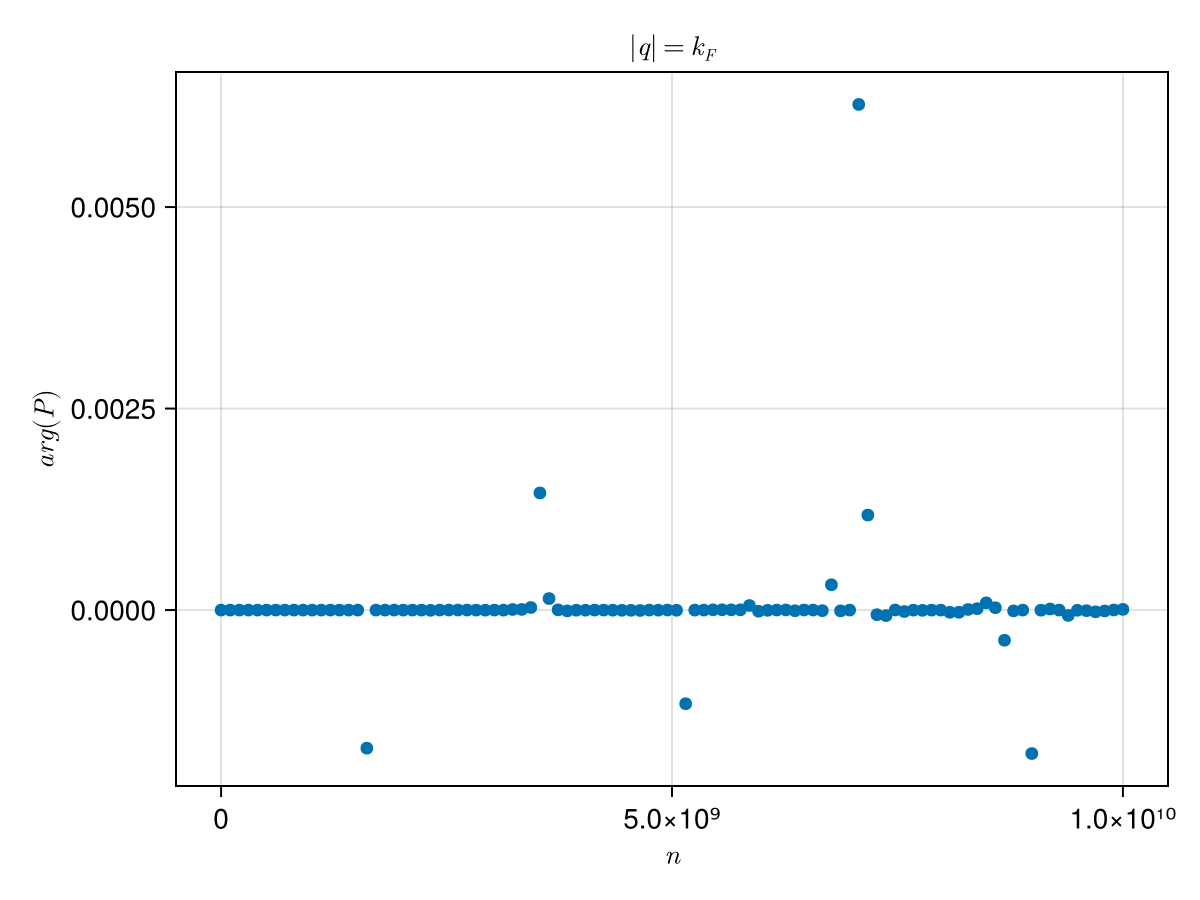

In [134]:
# create plot
P = Figure()
# create and configure axes
ax = Axis(P[1, 1], title = L"|q| = k_F", xlabel = L"n", ylabel = L"arg(P)")
scatter!(ax, n_list, overlaps)
P